In [1]:
import pandas as pd
import numpy as np
import csv
import math

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# use this code block to set column and row viewing size/width
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', 30)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

pd.options.display.float_format = '{:.4f}'.format

In [3]:
# read the metadata csv
pbsummary_df = pd.read_csv('../metadata.csv', delimiter=';')
pbsummary_df = pbsummary_df.drop_duplicates()
pbsummary_df

pbsummary_aarau = pd.read_csv('../metadata_aarau.csv', delimiter=';')
pbsummary_df = pd.concat([pbsummary_df, pbsummary_aarau], ignore_index=True)

pbsummary_df['subunit'].fillna(value='all', inplace=True)

In [4]:
# Get election id and vote type, so we know better to segragate approval and score votings
pbsummary_with_vote_type = pbsummary_df[['election_id', 'vote_type']]
print(pbsummary_with_vote_type['vote_type'].value_counts())

vote_type
approval      613
cumulative    104
ordinal        95
Name: count, dtype: int64


In [5]:
# reading the projects CSV and loading to dataframe
pbprojects_df = pd.read_csv('../projects.csv', delimiter=';')
pbprojects_df.drop_duplicates(inplace=True)
print(pbprojects_df.shape)

pbprojects_aarau = pd.read_csv('../projects_aarau.csv', delimiter=';')
pbprojects_df = pd.concat([pbprojects_df, pbprojects_aarau], ignore_index=True)

# merge the column vote_type into pbprojects_df
pbprojects_df = pd.merge(pbprojects_df, pbsummary_with_vote_type, on='election_id', how='inner')
print(pbprojects_df.shape)

(19077, 21)
(19110, 22)


In [6]:
# Check for projects where cost of a given project is zero

print("Projects with zero costs: ", pbprojects_df[pbprojects_df['cost'] == 0])

# Currently returns a single project ID which has been commented as been removed by City Council
invalid_projects = pbprojects_df[pbprojects_df['cost'] == 0][['project_id','election_id']]

# Excluding that single project id by checking with particular election id and project id
valid_pbprojects_df = pbprojects_df[~(pbprojects_df['project_id'].isin(invalid_projects['project_id']) & (pbprojects_df['election_id'].isin(invalid_projects['election_id'])))]
print(valid_pbprojects_df.shape)

Projects with zero costs:       election_id country    unit           subunit  instance project_id  cost  \
893           72  Poland  Gdynia  Grabówek | large      2020          5     0   

     project_voters_count  votes  score category  \
893                  1511     18    NaN      NaN   

                                                        name  englishName  \
893  PROJECT WAS REMOVED BY THE CITY FOR VIOLATING THE RULES          NaN   

    target  total_budget  budget_percent  is_mes_winner  is_greedy_winner  \
893    NaN   295110.0000          0.0000           True              True   

     is_phragmen_winner  latitude  longitude vote_type  
893                True       NaN        NaN  approval  
(19109, 22)


In [7]:
election_num_projects = valid_pbprojects_df.groupby(['election_id'])['project_id'].count().reset_index()
election_num_projects.rename(columns={'project_id': 'num_projects'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(election_num_projects, on='election_id', how='inner')

election_es_winner_num_projects = valid_pbprojects_df[valid_pbprojects_df['is_mes_winner'] == True].groupby(['election_id'])['project_id'].count().reset_index()
election_es_winner_num_projects.rename(columns={'project_id': 'es_num_projects'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(election_es_winner_num_projects, on='election_id', how='inner')

election_ug_winner_num_projects = valid_pbprojects_df[valid_pbprojects_df['is_greedy_winner'] == True].groupby(['election_id'])['project_id'].count().reset_index()
election_ug_winner_num_projects.rename(columns={'project_id': 'ug_num_projects'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(election_ug_winner_num_projects, on='election_id', how='inner')
valid_pbprojects_df

,election_id,country,unit,subunit,instance,project_id,cost,project_voters_count,votes,score,category,name,englishName,target,total_budget,budget_percent,is_mes_winner,is_greedy_winner,is_phragmen_winner,latitude,longitude,vote_type,num_projects,es_num_projects,ug_num_projects
0,1,France,Toulouse,ARENES,2019,1,7000,1494,215,NaN,NaN,Compostons ensemble !,NaN,NaN,1000000.0000,0.7000,True,True,True,NaN,NaN,cumulative,30,22,14
1,1,France,Toulouse,BELLEFONTAINE MILAN,2019,2,35000,1494,26,NaN,NaN,Panneau d'affichage électronique extérieur,NaN,NaN,1000000.0000,3.5000,False,False,False,NaN,NaN,cumulative,30,22,14
2,1,France,Toulouse,ARENES,2019,3,50000,1494,92,NaN,NaN,Eclairage public d’un chemin piéton-vélo rue Ella Maillart,NaN,NaN,1000000.0000,5.0000,True,False,True,NaN,NaN,cumulative,30,22,14
3,1,France,Toulouse,PRADETTES,2019,4,390000,1494,471,NaN,NaN,"Tous à la Ramée à vélo ! A pied, en trottinette et rollers !",NaN,NaN,1000000.0000,39.0000,False,True,False,NaN,NaN,cumulative,30,22,14
4,1,France,Toulouse,NEGRENEYS,2019,5,168000,1494,205,NaN,NaN,Le parc des Anges vu par ses usagers,NaN,NaN,1000000.0000,16.8000,True,True,True,NaN,NaN,cumulative,30,22,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19104,1000,Switzerland,Aarau,Aarau,2023,18,5000,1703,88,146.0000,"health,education,welfare",Processing birth,NaN,"adults,families with children",50000.0000,10.0000,False,False,False,NaN,NaN,cumulative,33,17,7
19105,1000,Switzerland,Aarau,Aarau,2023,17,3500,1703,67,102.0000,welfare,Senior Meeting,NaN,elderly,50000.0000,7.0000,False,False,False,NaN,NaN,cumulative,33,17,7
19106,1000,Switzerland,Aarau,Aarau,2023,27,4000,1703,69,97.0000,"public space,public transit and roads",New edition of Telli-Map,NaN,"children,families with children,elderly",50000.0000,8.0000,False,False,False,NaN,NaN,cumulative,33,17,7
19107,1000,Switzerland,Aarau,Aarau,2023,19,500,1703,56,85.0000,"welfare,education,health",Ways of Remembering,NaN,"youth,adults,elderly",50000.0000,1.0000,True,False,True,NaN,NaN,cumulative,33,17,7


In [8]:
MINIMUM_PROJECTS_NUMBER = 1
UPTO_TOP_TWENTY = 20

In [9]:
# election ids for Aarau and Wieliczka
aarau_election_id = valid_pbprojects_df[valid_pbprojects_df['country'] == 'Switzerland'].groupby(['election_id']).first().reset_index()['election_id']
aarau_election_id = aarau_election_id.values[0]

green_budget_election_id = valid_pbprojects_df[valid_pbprojects_df['unit'] == 'Wieliczka'].groupby(['election_id']).first().reset_index()['election_id']
green_budget_election_id = green_budget_election_id.values[0]

In [10]:
# Use describe to compare the number of projects in each instance and whether they are too varying or not
valid_pbprojects_df['num_projects'].describe()

count   19109.0000
mean       55.3930
std        46.7173
min         1.0000
25%        19.0000
50%        37.0000
75%        91.0000
max       220.0000
Name: num_projects, dtype: float64

In [11]:
print(valid_pbprojects_df['election_id'].nunique()) # No. of unique elections

# apply a filter such that select only those election instances for which number of proposed projects is at least MINIMUM_PROJECTS_NUMBER
filtered_valid_pbprojects_df = valid_pbprojects_df[valid_pbprojects_df['num_projects'] >= MINIMUM_PROJECTS_NUMBER]
print(filtered_valid_pbprojects_df.shape)
print(filtered_valid_pbprojects_df['election_id'].nunique())

812
(19109, 25)
812


## some additional filtering for score/points that can be used in cumulative voting as well as ordinal voting

In [12]:
# some discrepancy with the dataset here; so i will remove it for the time being; election id == 1 is the France Toulouse dataset which has empty 'Nan' values
filtered_valid_pbprojects_df = filtered_valid_pbprojects_df[filtered_valid_pbprojects_df['election_id'] != 1]

# print to check the votes and scores for cumulative voting instances
print(filtered_valid_pbprojects_df[((filtered_valid_pbprojects_df['vote_type'] == 'cumulative') | (filtered_valid_pbprojects_df['vote_type'] == 'ordinal')) & (~filtered_valid_pbprojects_df['score'].isna())][['project_id', 'election_id', 'votes', 'score']])

# update the votes values to reflect
for idx, row in filtered_valid_pbprojects_df.iterrows():
    if ((row['vote_type'] == 'cumulative') | (row['vote_type'] == 'ordinal')) and (~pd.isna(row['score'])):
        score_val = row['score']
        filtered_valid_pbprojects_df.at[idx, 'votes'] = int(score_val)

# re-checking if changes have been reflected
print(filtered_valid_pbprojects_df[(filtered_valid_pbprojects_df['vote_type'] == 'cumulative') & (~filtered_valid_pbprojects_df['score'].isna())][['project_id', 'election_id', 'votes', 'score']])
print(filtered_valid_pbprojects_df.shape)

      project_id  election_id  votes      score
30           409            2   1379 12822.0000
31           581            2   1342 12449.0000
32           604            2   1279 11673.0000
33           275            2   1790 11584.0000
34           182            2    982  8686.0000
...          ...          ...    ...        ...
19104         18         1000     88   146.0000
19105         17         1000     67   102.0000
19106         27         1000     69    97.0000
19107         19         1000     56    85.0000
19108          6         1000     44    85.0000

[4050 rows x 4 columns]
      project_id  election_id  votes      score
30           409            2  12822 12822.0000
31           581            2  12449 12449.0000
32           604            2  11673 11673.0000
33           275            2  11584 11584.0000
34           182            2   8686  8686.0000
...          ...          ...    ...        ...
19104         18         1000    146   146.0000
19105         1

## filter projects within election such that they contain the range of projects with highest votes to lowest winning vote for each of UG and ES

In [13]:
# for UG
ug_winning_projects_with_lowest_votes_df = filtered_valid_pbprojects_df[(filtered_valid_pbprojects_df['is_greedy_winner'] == True)].groupby(['election_id'])['votes'].min().reset_index()
ug_winning_projects_with_lowest_votes_df.rename(columns={'votes': 'ug_lowest_winning_votes'}, inplace=True)
# merge and write to a new dataframe
ug_filtered_valid_pbprojects_df = filtered_valid_pbprojects_df.merge(ug_winning_projects_with_lowest_votes_df, on='election_id', how='inner')
print(ug_filtered_valid_pbprojects_df.shape)
# select the subset of projects with at least minimum winning votes
ug_filtered_valid_pbprojects_df = ug_filtered_valid_pbprojects_df[ug_filtered_valid_pbprojects_df['votes'] >= ug_filtered_valid_pbprojects_df['ug_lowest_winning_votes']]
print(ug_filtered_valid_pbprojects_df.shape)


# for ES
es_winning_projects_with_lowest_votes_df = filtered_valid_pbprojects_df[(filtered_valid_pbprojects_df['is_mes_winner'] == True)].groupby(['election_id'])['votes'].min().reset_index()
es_winning_projects_with_lowest_votes_df.rename(columns={'votes': 'es_lowest_winning_votes'}, inplace=True)
# merge and write to a new dataframe
es_filtered_valid_pbprojects_df = filtered_valid_pbprojects_df.merge(es_winning_projects_with_lowest_votes_df, on='election_id', how='inner')
print(es_filtered_valid_pbprojects_df.shape)
# select the subset of projects with at least minimum winning votes
es_filtered_valid_pbprojects_df = es_filtered_valid_pbprojects_df[es_filtered_valid_pbprojects_df['votes'] >= es_filtered_valid_pbprojects_df['es_lowest_winning_votes']]
print(es_filtered_valid_pbprojects_df.shape)

(19079, 26)
(10680, 26)
(19079, 26)
(17292, 26)


In [14]:
# create a column for ranking projects grouped by each election id, based on the number of votes received; for each of UG and ES
ug_filtered_valid_pbprojects_df['project_votes_rank'] = ug_filtered_valid_pbprojects_df.groupby(['election_id'])['votes'].rank(method='dense', ascending=False)
print(ug_filtered_valid_pbprojects_df.shape)
print(ug_filtered_valid_pbprojects_df.head(2))

es_filtered_valid_pbprojects_df['project_votes_rank'] = es_filtered_valid_pbprojects_df.groupby(['election_id'])['votes'].rank(method='dense', ascending=False)
print(es_filtered_valid_pbprojects_df.shape)
print(es_filtered_valid_pbprojects_df.head(2))

(10680, 27)
   election_id country         unit subunit  instance project_id     cost  \
0            2  Poland  Czestochowa     NaN      2020        409  1150000   
1            2  Poland  Czestochowa     NaN      2020        581  1116000   

   project_voters_count  votes      score category  \
0                 16978  12822 12822.0000      NaN   
1                 16978  12449 12449.0000      NaN   

                                                                                                                                                        name  \
0                                     Rewitalizacja, zmiana nawierzchni na boiskach hybrydowych MOSIR Raków oraz doposażenie specjalistyczne infrastruktury”   
1  „AS” – AKTYWNE SPOŁECZEŃSTWO - DOPOSAŻENIE PLACÓW RODZINNEJ REKREACJI W DZIELNICACH: BŁESZNO, BRZEZINY, RAKÓW, STARE MIASTO, STRADOM I WYCZERPY – ANIOŁÓW   

   englishName target  total_budget  budget_percent  is_mes_winner  \
0          NaN    NaN  2367122.0000       

In [15]:
# assign column values for each of UG and ES notifying whether or not a vote project is selected or not
es_cols_to_select = ['election_id']
ug_cols_to_select = ['election_id']

for num in range(1, UPTO_TOP_TWENTY + 1):
    ug_cols_to_select.append(f'top_{num}_project_selected_by_ug')
    es_cols_to_select.append(f'top_{num}_project_selected_by_es')

# for UG
for idx, row in ug_filtered_valid_pbprojects_df.iterrows():
    for i in range(1, UPTO_TOP_TWENTY + 1):
        if i <= row['num_projects']:
            ug_filtered_valid_pbprojects_df.at[idx, f'top_{i}_project_selected_by_ug'] = 1 if ((row['project_votes_rank'] == i) and (row['is_greedy_winner'] == True)) else 0
        else:
            ug_filtered_valid_pbprojects_df.at[idx, f'top_{i}_project_selected_by_ug'] = np.nan
ug_election_project_ranking_df_non_grouped = ug_filtered_valid_pbprojects_df[ug_cols_to_select]
# the following use of .any() may not be the most optimal way, but it works. we want to see if there is any one winning projects for a given rank
# because in the above iteration, each row is matched for rank number and selection by UG or ES, we can use grouping by election id and then selection any one occurrences
# for the rank selection column where there is a 1 value
ug_election_project_ranking_df = ug_election_project_ranking_df_non_grouped.groupby(['election_id']).any()
print(ug_election_project_ranking_df.shape)

# for ES
for idx, row in es_filtered_valid_pbprojects_df.iterrows():
    for i in range(1, UPTO_TOP_TWENTY + 1):
        if i <= row['num_projects']:
            es_filtered_valid_pbprojects_df.at[idx, f'top_{i}_project_selected_by_es'] = 1 if ((row['project_votes_rank'] == i) and (row['is_mes_winner'] == True)) else 0
        else:
            es_filtered_valid_pbprojects_df.at[idx, f'top_{i}_project_selected_by_es'] = np.nan
es_election_project_ranking_df_non_grouped = es_filtered_valid_pbprojects_df[es_cols_to_select]
# the following use of .any() may not be the most optimal way, but it works. we want to see if there is any one winning projects for a given rank
# because in the above iteration, each row is matched for rank number and selection by UG or ES, we can use grouping by election id and then selection any one occurrences
# for the rank selection column where there is a 1 value
es_election_project_ranking_df = es_election_project_ranking_df_non_grouped.groupby(['election_id']).any()
print(es_election_project_ranking_df.shape)


(811, 20)
(811, 20)


In [16]:
ug_miss_rate_avg_map = {}
ug_selection_rate_avg_map = {}
es_miss_rate_avg_map = {}
es_selection_rate_avg_map = {}

ug_miss_rate_sd_map = {}
es_miss_rate_sd_map = {}

for i in range(1, UPTO_TOP_TWENTY + 1):
    # the mean is obtained as selection rate from True or False values, we use 1- to get non-selection rate
    es_miss_rate_avg_map[i] = round(1 - es_election_project_ranking_df[f'top_{i}_project_selected_by_es'].mean(), 3)
    es_selection_rate_avg_map[i] = round(es_election_project_ranking_df[f'top_{i}_project_selected_by_es'].mean(), 3)
    es_miss_rate_sd_map[i] = round(es_election_project_ranking_df[f'top_{i}_project_selected_by_es'].std(), 3)

    ug_miss_rate_avg_map[i] = round(1 - ug_election_project_ranking_df[f'top_{i}_project_selected_by_ug'].mean(), 3)
    ug_miss_rate_sd_map[i] = round(ug_election_project_ranking_df[f'top_{i}_project_selected_by_ug'].std(), 3)
    ug_selection_rate_avg_map[i] = round(ug_election_project_ranking_df[f'top_{i}_project_selected_by_ug'].mean(), 3)


print(ug_miss_rate_avg_map)
print(ug_miss_rate_sd_map)
print(es_miss_rate_avg_map)
print(es_miss_rate_sd_map)


{1: 0.0, 2: 0.232, 3: 0.296, 4: 0.395, 5: 0.467, 6: 0.498, 7: 0.538, 8: 0.6, 9: 0.644, 10: 0.704, 11: 0.711, 12: 0.772, 13: 0.795, 14: 0.83, 15: 0.841, 16: 0.873, 17: 0.866, 18: 0.903, 19: 0.924, 20: 0.919}
{1: 0.0, 2: 0.422, 3: 0.457, 4: 0.489, 5: 0.499, 6: 0.5, 7: 0.499, 8: 0.49, 9: 0.479, 10: 0.457, 11: 0.453, 12: 0.42, 13: 0.404, 14: 0.376, 15: 0.366, 16: 0.333, 17: 0.341, 18: 0.297, 19: 0.266, 20: 0.274}
{1: 0.232, 2: 0.305, 3: 0.35, 4: 0.409, 5: 0.395, 6: 0.466, 7: 0.45, 8: 0.514, 9: 0.514, 10: 0.583, 11: 0.591, 12: 0.642, 13: 0.644, 14: 0.666, 15: 0.692, 16: 0.711, 17: 0.724, 18: 0.756, 19: 0.776, 20: 0.794}
{1: 0.422, 2: 0.461, 3: 0.477, 4: 0.492, 5: 0.489, 6: 0.499, 7: 0.498, 8: 0.5, 9: 0.5, 10: 0.493, 11: 0.492, 12: 0.48, 13: 0.479, 14: 0.472, 15: 0.462, 16: 0.453, 17: 0.447, 18: 0.43, 19: 0.417, 20: 0.405}


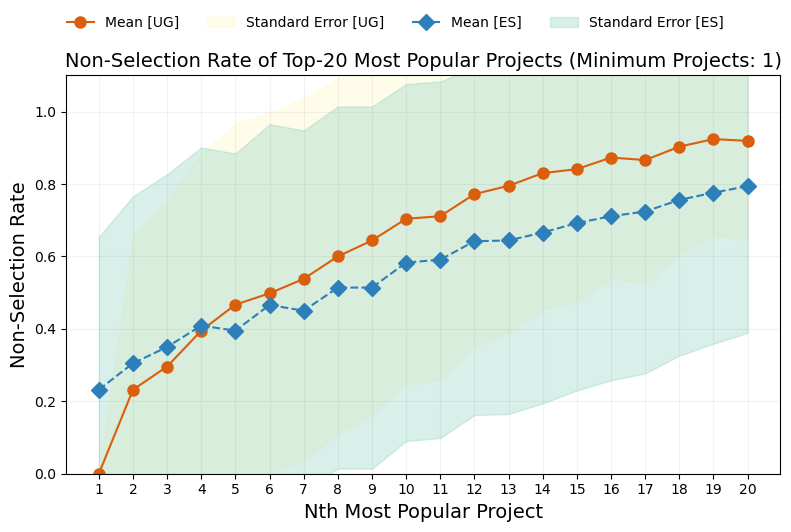

In [17]:
xlabells = []
for k in ug_miss_rate_avg_map.keys():
    x = str(k)
    xlabells.append(x)

# Plotting the non-selection rate at different percentages vlaues
fig, ax = plt.subplots(figsize=(8, 5))

ug_avg_miss_rate_values = [v for v in ug_miss_rate_avg_map.values()]
ug_avg_miss_rate_values = np.array(ug_avg_miss_rate_values)

es_avg_miss_rate_values = [v for v in es_miss_rate_avg_map.values()]
es_avg_miss_rate_values = np.array(es_avg_miss_rate_values)

ug_std_miss_rate_values = [v for v in ug_miss_rate_sd_map.values()]
ug_std_miss_rate_values = np.array(ug_std_miss_rate_values)

es_std_miss_rate_values = [v for v in es_miss_rate_sd_map.values()]
es_std_miss_rate_values = np.array(es_std_miss_rate_values)

# UG-means with one standard error
ax.plot(range(len(ug_avg_miss_rate_values)), ug_avg_miss_rate_values, color='#d95f0e', label='Mean [UG]', marker='o', markersize=8)
ax.fill_between(range(len(ug_avg_miss_rate_values)), ug_avg_miss_rate_values - ug_std_miss_rate_values, ug_avg_miss_rate_values + ug_std_miss_rate_values, color='#fff7bc', alpha=0.3, label='Standard Error [UG]') #, where=((ug_avg_miss_rate_values - ug_std_miss_rate_values) >= 0) & ((ug_avg_miss_rate_values + ug_std_miss_rate_values) <= 1))

# ES-means with one standard error
ax.plot(range(len(es_avg_miss_rate_values)), es_avg_miss_rate_values, color='#2c7fb8', label='Mean [ES]', marker='D', markersize=8, linestyle='--')
ax.fill_between(range(len(es_avg_miss_rate_values)), es_avg_miss_rate_values - es_std_miss_rate_values, es_avg_miss_rate_values + es_std_miss_rate_values, color='#7fcdbb', alpha=0.3, label='Standard Error [ES]') #, where=((es_avg_miss_rate_values - es_std_miss_rate_values) >= 0) & ((es_avg_miss_rate_values + es_std_miss_rate_values) <= 1))
ax.set_ylim([0, 1.1])

ax.set_title(f'Non-Selection Rate of Top-{UPTO_TOP_TWENTY} Most Popular Projects (Minimum Projects: {MINIMUM_PROJECTS_NUMBER})', loc='center', fontsize=14)
ax.set_ylabel('Non-Selection Rate', fontsize=14)
ax.set_xlabel('Nth Most Popular Project', fontsize=14)
ax.grid(axis='both', which='major', color='gray', alpha=0.1)

# Customize legend
handles, labels = ax.get_legend_handles_labels()

# Create legend outside of the main plot
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.99), ncols=4, frameon=False, fontsize=10)

ax.set_xticks(range(len(es_avg_miss_rate_values)))
ax.set_xticklabels(xlabells)

plt.tight_layout()
plt.show()

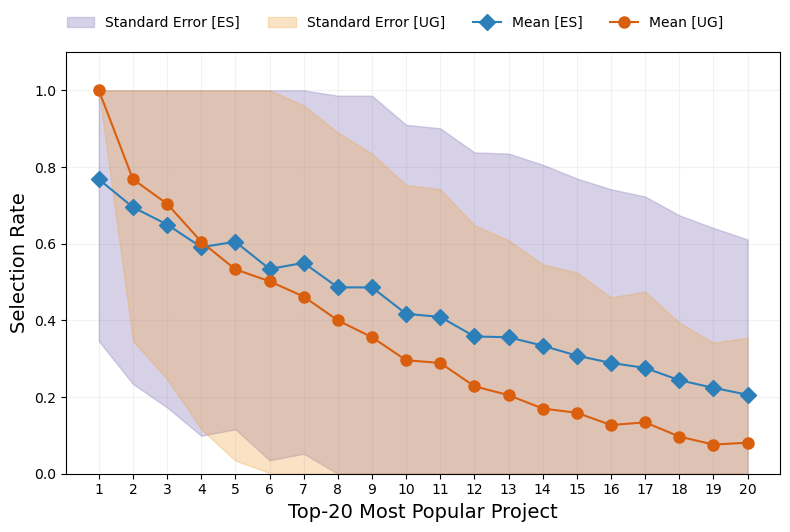

In [18]:
xlabells = []
for k in ug_selection_rate_avg_map.keys():
    x = str(k)
    xlabells.append(x)

# Plotting the non-selection rate at different percentages vlaues
fig, ax = plt.subplots(figsize=(8, 5))

ug_avg_selection_rate_values = [v for v in ug_selection_rate_avg_map.values()]
ug_avg_selection_rate_values = np.array(ug_avg_selection_rate_values)

es_avg_selection_rate_values = [v for v in es_selection_rate_avg_map.values()]
es_avg_selection_rate_values = np.array(es_avg_selection_rate_values)

ug_std_miss_rate_values = [v for v in ug_miss_rate_sd_map.values()]
ug_std_miss_rate_values = np.array(ug_std_miss_rate_values)

es_std_miss_rate_values = [v for v in es_miss_rate_sd_map.values()]
es_std_miss_rate_values = np.array(es_std_miss_rate_values)

# UG-means with one standard error
ug_std_err_lower_limit_arr = [ max(ug_avg - ug_std, 0) for ug_avg, ug_std in zip(ug_avg_selection_rate_values, ug_std_miss_rate_values) ]
ug_std_err_upper_limit_arr = [ min(ug_avg + ug_std, 1) for ug_avg, ug_std in zip(ug_avg_selection_rate_values, ug_std_miss_rate_values) ]

# ES-means with one standard error
es_std_err_lower_limit_arr = [ max(es_avg - es_std, 0) for es_avg, es_std in zip(es_avg_selection_rate_values, es_std_miss_rate_values) ]
es_std_err_upper_limit_arr = [ min(es_avg + es_std, 1) for es_avg, es_std in zip(es_avg_selection_rate_values, es_std_miss_rate_values) ]

ax.fill_between(range(len(es_avg_selection_rate_values)), es_std_err_lower_limit_arr, es_std_err_upper_limit_arr, color='#998ec3', alpha=0.4, label='Standard Error [ES]')
ax.fill_between(range(len(ug_avg_selection_rate_values)), ug_std_err_lower_limit_arr, ug_std_err_upper_limit_arr, color='#f1a340', alpha=0.3, label='Standard Error [UG]')
ax.plot(range(len(es_avg_selection_rate_values)), es_avg_selection_rate_values, color='#2c7fb8', label='Mean [ES]', marker='D', markersize=8)
ax.plot(range(len(ug_avg_selection_rate_values)), ug_avg_selection_rate_values, color='#d95f0e', label='Mean [UG]', marker='o', markersize=8)
ax.set_ylim([0, 1.1])

# ax.set_title(f'Selection Rate of Top-{UPTO_TOP_TWENTY} Most Popular Projects', loc='center', fontsize=14)
ax.set_ylabel('Selection Rate', fontsize=14)
ax.set_xlabel('Top-20 Most Popular Project', fontsize=14)
ax.grid(axis='both', which='major', color='gray', alpha=0.1)

# Customize legend
handles, labels = ax.get_legend_handles_labels()

# Create legend outside of the main plot
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.99), ncols=4, frameon=False, fontsize=10)

ax.set_xticks(range(len(es_avg_miss_rate_values)))
ax.set_xticklabels(xlabells)

plt.tight_layout()
plt.show()


### Top-20 Popular Projects and Their Cost Quartiles Distribution

In [19]:
# remove the toulouse data because it was incorrect; 
valid_pbprojects_df = valid_pbprojects_df[valid_pbprojects_df['unit'] != 'Toulouse']
valid_pbprojects_df

,election_id,country,unit,subunit,instance,project_id,cost,project_voters_count,votes,score,category,name,englishName,target,total_budget,budget_percent,is_mes_winner,is_greedy_winner,is_phragmen_winner,latitude,longitude,vote_type,num_projects,es_num_projects,ug_num_projects
30,2,Poland,Czestochowa,NaN,2020,409,1150000,16978,1379,12822.0000,NaN,"Rewitalizacja, zmiana nawierzchni na boiskach hybrydowych MOSIR Raków oraz doposażenie specjalistyczne infrastruktury”",NaN,NaN,2367122.0000,48.5820,False,True,False,NaN,NaN,cumulative,90,35,7
31,2,Poland,Czestochowa,NaN,2020,581,1116000,16978,1342,12449.0000,NaN,"„AS” – AKTYWNE SPOŁECZEŃSTWO - DOPOSAŻENIE PLACÓW RODZINNEJ REKREACJI W DZIELNICACH: BŁESZNO, BRZEZINY, RAKÓW, STARE MIASTO, STRADOM I WYCZERPY – ANIOŁÓW",NaN,NaN,2367122.0000,47.1460,False,True,False,NaN,NaN,cumulative,90,35,7
32,2,Poland,Czestochowa,NaN,2020,604,1140000,16978,1279,11673.0000,NaN,Modernizacja boiska piłkarskiego KOS Victoria 1922 Częstochowa wraz z infrastrukturą,NaN,NaN,2367122.0000,48.1600,False,False,False,NaN,NaN,cumulative,90,35,7
33,2,Poland,Czestochowa,NaN,2020,275,172500,16978,1790,11584.0000,NaN,„Częstochowianie bezdomnym zwierzętom.”,NaN,NaN,2367122.0000,7.2870,True,False,True,NaN,NaN,cumulative,90,35,7
34,2,Poland,Czestochowa,NaN,2020,182,496000,16978,982,8686.0000,NaN,Nowy wygląd Biblioteki przy ul. Gombrowicza 15,NaN,NaN,2367122.0000,20.9540,True,False,True,NaN,NaN,cumulative,90,35,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19104,1000,Switzerland,Aarau,Aarau,2023,18,5000,1703,88,146.0000,"health,education,welfare",Processing birth,NaN,"adults,families with children",50000.0000,10.0000,False,False,False,NaN,NaN,cumulative,33,17,7
19105,1000,Switzerland,Aarau,Aarau,2023,17,3500,1703,67,102.0000,welfare,Senior Meeting,NaN,elderly,50000.0000,7.0000,False,False,False,NaN,NaN,cumulative,33,17,7
19106,1000,Switzerland,Aarau,Aarau,2023,27,4000,1703,69,97.0000,"public space,public transit and roads",New edition of Telli-Map,NaN,"children,families with children,elderly",50000.0000,8.0000,False,False,False,NaN,NaN,cumulative,33,17,7
19107,1000,Switzerland,Aarau,Aarau,2023,19,500,1703,56,85.0000,"welfare,education,health",Ways of Remembering,NaN,"youth,adults,elderly",50000.0000,1.0000,True,False,True,NaN,NaN,cumulative,33,17,7


In [20]:
# reflecting the appropriate column that stores total votes based on voting type
valid_pbprojects_df['votes'] = np.where((valid_pbprojects_df['vote_type'] == 'approval'), valid_pbprojects_df['votes'], valid_pbprojects_df['score'])
valid_pbprojects_df.drop(columns=['name', 'country', 'unit', 'subunit', 'instance', 'score', 'latitude', 'category', 'budget_percent', 'total_budget', 'target', 'longitude', 'englishName', 'es_num_projects', 'ug_num_projects', 'is_greedy_winner', 'is_mes_winner', 'is_phragmen_winner'], inplace=True)

C:\Users\scsmah\AppData\Local\Temp\ipykernel_30000\2492754029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_pbprojects_df['votes'] = np.where((valid_pbprojects_df['vote_type'] == 'approval'), valid_pbprojects_df['votes'], valid_pbprojects_df['score'])
C:\Users\scsmah\AppData\Local\Temp\ipykernel_30000\2492754029.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_pbprojects_df.drop(columns=['name', 'country', 'unit', 'subunit', 'instance', 'score', 'latitude', 'category', 'budget_percent', 'total_budget', 'target', 'longitude', 'englishName', 'e

In [21]:
q1_cost = valid_pbprojects_df.groupby(['election_id'])['cost'].quantile(0.25).reset_index(name='q1_cost')
q2_cost = valid_pbprojects_df.groupby(['election_id'])['cost'].quantile(0.5).reset_index(name='q2_cost')
q3_cost = valid_pbprojects_df.groupby(['election_id'])['cost'].quantile(0.75).reset_index(name='q3_cost')
q4_cost = valid_pbprojects_df.groupby(['election_id'])['cost'].quantile(1).reset_index(name='q4_cost')

valid_pbprojects_df = valid_pbprojects_df.merge(q1_cost, on='election_id', how='inner')
valid_pbprojects_df = valid_pbprojects_df.merge(q2_cost, on='election_id', how='inner')
valid_pbprojects_df = valid_pbprojects_df.merge(q3_cost, on='election_id', how='inner')
valid_pbprojects_df = valid_pbprojects_df.merge(q4_cost, on='election_id', how='inner')

valid_pbprojects_df

,election_id,project_id,cost,project_voters_count,votes,vote_type,num_projects,q1_cost,q2_cost,q3_cost,q4_cost
0,2,409,1150000,16978,12822.0000,cumulative,90,50000.0000,143590.0000,346925.0000,1183561.0000
1,2,581,1116000,16978,12449.0000,cumulative,90,50000.0000,143590.0000,346925.0000,1183561.0000
2,2,604,1140000,16978,11673.0000,cumulative,90,50000.0000,143590.0000,346925.0000,1183561.0000
3,2,275,172500,16978,11584.0000,cumulative,90,50000.0000,143590.0000,346925.0000,1183561.0000
4,2,182,496000,16978,8686.0000,cumulative,90,50000.0000,143590.0000,346925.0000,1183561.0000
...,...,...,...,...,...,...,...,...,...,...,...
19074,1000,18,5000,1703,146.0000,cumulative,33,2300.0000,4000.0000,10000.0000,25000.0000
19075,1000,17,3500,1703,102.0000,cumulative,33,2300.0000,4000.0000,10000.0000,25000.0000
19076,1000,27,4000,1703,97.0000,cumulative,33,2300.0000,4000.0000,10000.0000,25000.0000
19077,1000,19,500,1703,85.0000,cumulative,33,2300.0000,4000.0000,10000.0000,25000.0000


In [22]:
valid_pbprojects_df['popularity_rank'] = valid_pbprojects_df.groupby(['election_id'])['votes'].rank(method='dense', ascending=False)
valid_pbprojects_df

,election_id,project_id,cost,project_voters_count,votes,vote_type,num_projects,q1_cost,q2_cost,q3_cost,q4_cost,popularity_rank
0,2,409,1150000,16978,12822.0000,cumulative,90,50000.0000,143590.0000,346925.0000,1183561.0000,1.0000
1,2,581,1116000,16978,12449.0000,cumulative,90,50000.0000,143590.0000,346925.0000,1183561.0000,2.0000
2,2,604,1140000,16978,11673.0000,cumulative,90,50000.0000,143590.0000,346925.0000,1183561.0000,3.0000
3,2,275,172500,16978,11584.0000,cumulative,90,50000.0000,143590.0000,346925.0000,1183561.0000,4.0000
4,2,182,496000,16978,8686.0000,cumulative,90,50000.0000,143590.0000,346925.0000,1183561.0000,5.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
19074,1000,18,5000,1703,146.0000,cumulative,33,2300.0000,4000.0000,10000.0000,25000.0000,29.0000
19075,1000,17,3500,1703,102.0000,cumulative,33,2300.0000,4000.0000,10000.0000,25000.0000,30.0000
19076,1000,27,4000,1703,97.0000,cumulative,33,2300.0000,4000.0000,10000.0000,25000.0000,31.0000
19077,1000,19,500,1703,85.0000,cumulative,33,2300.0000,4000.0000,10000.0000,25000.0000,32.0000


In [23]:
# Initialize 4 different columns for labels
valid_pbprojects_df['in_first_quartile'] = 0
valid_pbprojects_df['in_second_quartile'] = 0
valid_pbprojects_df['in_third_quartile'] = 0
valid_pbprojects_df['in_fourth_quartile'] = 0

# Iterate through rows and update the new columns
for index, row in valid_pbprojects_df.iterrows():
    if row['cost'] <= row['q1_cost']:
        valid_pbprojects_df.at[index, 'in_first_quartile'] = 1
    elif row['cost'] > row['q1_cost'] and row['cost'] <= row['q2_cost']:
        valid_pbprojects_df.at[index, 'in_second_quartile'] = 1
    elif row['cost'] > row['q2_cost'] and row['cost'] <= row['q3_cost']:
        valid_pbprojects_df.at[index, 'in_third_quartile'] = 1
    else:
        valid_pbprojects_df.at[index, 'in_fourth_quartile'] = 1

In [24]:
valid_pbprojects_df

,election_id,project_id,cost,project_voters_count,votes,vote_type,num_projects,q1_cost,q2_cost,q3_cost,q4_cost,popularity_rank,in_first_quartile,in_second_quartile,in_third_quartile,in_fourth_quartile
0,2,409,1150000,16978,12822.0000,cumulative,90,50000.0000,143590.0000,346925.0000,1183561.0000,1.0000,0,0,0,1
1,2,581,1116000,16978,12449.0000,cumulative,90,50000.0000,143590.0000,346925.0000,1183561.0000,2.0000,0,0,0,1
2,2,604,1140000,16978,11673.0000,cumulative,90,50000.0000,143590.0000,346925.0000,1183561.0000,3.0000,0,0,0,1
3,2,275,172500,16978,11584.0000,cumulative,90,50000.0000,143590.0000,346925.0000,1183561.0000,4.0000,0,0,1,0
4,2,182,496000,16978,8686.0000,cumulative,90,50000.0000,143590.0000,346925.0000,1183561.0000,5.0000,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19074,1000,18,5000,1703,146.0000,cumulative,33,2300.0000,4000.0000,10000.0000,25000.0000,29.0000,0,0,1,0
19075,1000,17,3500,1703,102.0000,cumulative,33,2300.0000,4000.0000,10000.0000,25000.0000,30.0000,0,1,0,0
19076,1000,27,4000,1703,97.0000,cumulative,33,2300.0000,4000.0000,10000.0000,25000.0000,31.0000,0,1,0,0
19077,1000,19,500,1703,85.0000,cumulative,33,2300.0000,4000.0000,10000.0000,25000.0000,32.0000,1,0,0,0


In [25]:
rank_vs_cost_quartile_df = pd.DataFrame(columns=['popularity', 'q1_cost_count', 'q2_cost_count', 'q3_cost_count', 'q4_cost_count'])

for popularity_val in range(1, 21):
    cur_popularity_first_quartile_count = valid_pbprojects_df[(valid_pbprojects_df['popularity_rank'] == popularity_val) & (valid_pbprojects_df['in_first_quartile'] == 1)].groupby(['popularity_rank'])['project_id'].count().values[0]
    cur_popularity_second_quartile_count = valid_pbprojects_df[(valid_pbprojects_df['popularity_rank'] == popularity_val) & (valid_pbprojects_df['in_second_quartile'] == 1)].groupby(['popularity_rank'])['project_id'].count().values[0]
    cur_popularity_third_quartile_count = valid_pbprojects_df[(valid_pbprojects_df['popularity_rank'] == popularity_val) & (valid_pbprojects_df['in_third_quartile'] == 1)].groupby(['popularity_rank'])['project_id'].count().values[0]
    cur_popularity_fourth_quartile_count = valid_pbprojects_df[(valid_pbprojects_df['popularity_rank'] == popularity_val) & (valid_pbprojects_df['in_fourth_quartile'] == 1)].groupby(['popularity_rank'])['project_id'].count().values[0]
    
    cur_row = pd.DataFrame({
        'popularity': popularity_val, 
        'q1_cost_count': [cur_popularity_first_quartile_count], 
        'q2_cost_count': [cur_popularity_second_quartile_count],
        'q3_cost_count': [cur_popularity_third_quartile_count],
        'q4_cost_count': [cur_popularity_fourth_quartile_count]
    })

    rank_vs_cost_quartile_df = pd.concat([rank_vs_cost_quartile_df, cur_row], ignore_index=True)

rank_vs_cost_quartile_df


,popularity,q1_cost_count,q2_cost_count,q3_cost_count,q4_cost_count
0,1,160,154,151,348
1,2,206,175,186,238
2,3,214,200,155,217
3,4,214,186,172,192
4,5,245,157,163,171
5,6,216,184,127,168
6,7,195,182,148,143
7,8,176,181,128,145
8,9,177,160,147,112
9,10,149,170,108,128


In [26]:
rank_vs_cost_quartile_df['all_quartiles_cost_count'] = rank_vs_cost_quartile_df['q1_cost_count'] + rank_vs_cost_quartile_df['q2_cost_count'] + rank_vs_cost_quartile_df['q3_cost_count'] + rank_vs_cost_quartile_df['q4_cost_count']
rank_vs_cost_quartile_df['norm_q1_cost_count'] = rank_vs_cost_quartile_df['q1_cost_count'] / rank_vs_cost_quartile_df['all_quartiles_cost_count']
rank_vs_cost_quartile_df['norm_q2_cost_count'] = rank_vs_cost_quartile_df['q2_cost_count'] / rank_vs_cost_quartile_df['all_quartiles_cost_count']
rank_vs_cost_quartile_df['norm_q3_cost_count'] = rank_vs_cost_quartile_df['q3_cost_count'] / rank_vs_cost_quartile_df['all_quartiles_cost_count']
rank_vs_cost_quartile_df['norm_q4_cost_count'] = rank_vs_cost_quartile_df['q4_cost_count'] / rank_vs_cost_quartile_df['all_quartiles_cost_count']
rank_vs_cost_quartile_df

,popularity,q1_cost_count,q2_cost_count,q3_cost_count,q4_cost_count,all_quartiles_cost_count,norm_q1_cost_count,norm_q2_cost_count,norm_q3_cost_count,norm_q4_cost_count
0,1,160,154,151,348,813,0.1968,0.1894,0.1857,0.4280
1,2,206,175,186,238,805,0.2559,0.2174,0.2311,0.2957
2,3,214,200,155,217,786,0.2723,0.2545,0.1972,0.2761
3,4,214,186,172,192,764,0.2801,0.2435,0.2251,0.2513
4,5,245,157,163,171,736,0.3329,0.2133,0.2215,0.2323
5,6,216,184,127,168,695,0.3108,0.2647,0.1827,0.2417
6,7,195,182,148,143,668,0.2919,0.2725,0.2216,0.2141
7,8,176,181,128,145,630,0.2794,0.2873,0.2032,0.2302
8,9,177,160,147,112,596,0.2970,0.2685,0.2466,0.1879
9,10,149,170,108,128,555,0.2685,0.3063,0.1946,0.2306


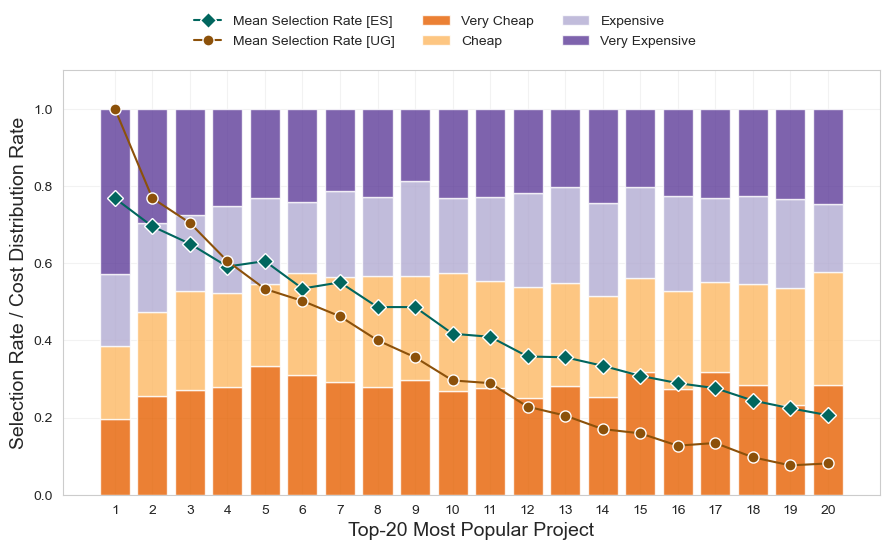

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

quartile_labels_map = {
    'q1': 'Very Cheap',
    'q2': 'Cheap',
    'q3': 'Expensive',
    'q4': 'Very Expensive'
}

quartile_color_palette = ['#e66101','#fdb863','#b2abd2','#5e3c99']

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(9, 5))

bottom = np.zeros(20)

for (idx, (quartile, quartile_labels)) in enumerate(quartile_labels_map.items()):
    ax.bar(rank_vs_cost_quartile_df['popularity']-1, rank_vs_cost_quartile_df[f'norm_{quartile}_cost_count'], bottom=bottom, label=quartile_labels, color=quartile_color_palette[idx], alpha=0.8) # we use -1 in the x-index, because popularity starts at 1, and bar index starts at 0
    bottom += rank_vs_cost_quartile_df[f'norm_{quartile}_cost_count']

ug_avg_selection_rate_values = [v for v in ug_selection_rate_avg_map.values()]
ug_avg_selection_rate_values = np.array(ug_avg_selection_rate_values)

es_avg_selection_rate_values = [v for v in es_selection_rate_avg_map.values()]
es_avg_selection_rate_values = np.array(es_avg_selection_rate_values)

ug_std_miss_rate_values = [v for v in ug_miss_rate_sd_map.values()]
ug_std_miss_rate_values = np.array(ug_std_miss_rate_values)

es_std_miss_rate_values = [v for v in es_miss_rate_sd_map.values()]
es_std_miss_rate_values = np.array(es_std_miss_rate_values)


ax.plot(range(len(es_avg_selection_rate_values)), es_avg_selection_rate_values, markeredgecolor='white', color='#01665e', label='Mean Selection Rate [ES]', marker='D', markersize=8)
ax.plot(range(len(ug_avg_selection_rate_values)), ug_avg_selection_rate_values, markeredgecolor='white', color='#8c510a', label='Mean Selection Rate [UG]', marker='o', markersize=8)
ax.set_ylim([0, 1.1])

ax.set_ylabel('Selection Rate / Cost Distribution Rate', fontsize=14)
ax.set_xlabel('Top-20 Most Popular Project', fontsize=14)
ax.grid(axis='both', which='major', color='gray', alpha=0.1)

# Customize legend
handles, labels = ax.get_legend_handles_labels()

# Create legend outside of the main plot
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.99), ncols=3, frameon=False, fontsize=10)

ax.set_xticks(range(len(es_avg_miss_rate_values)))
ax.set_xticklabels(xlabells)
ax.grid(axis='both', which='major', color='gray', alpha=0.1)

plt.tight_layout()
plt.show()